### **This Notebook Detects Representative Spectra within each Surface**

This is done by building a similarity graph between each spectra, based on the Gaussian Kernel, then detecting the most representative spectra within each surface based on the PageRank centrality.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [4]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [5]:
sample = df[df['SurID'] == '210526-3']

In [6]:
#sns.lineplot(data=sample, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [7]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,-0.019205
1,201210-1-00,294,400.91116,201210-1,Normal,-0.111056
2,201210-1-00,295,401.59454,201210-1,Normal,-0.182767
3,201210-1-00,296,402.27789,201210-1,Normal,-0.236198
4,201210-1-00,297,402.96127,201210-1,Normal,-0.273213
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-1.510989
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-1.520719
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-1.539756
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-1.569132


In [8]:
pivoted_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None

statuses = df[['SpecID', 'Status']].drop_duplicates()

pivoted_df = pd.merge(pivoted_df, statuses, on='SpecID')
pivoted_df = pivoted_df.set_index('SpecID')

pivoted_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.019205,-0.111056,-0.182767,-0.236198,-0.273213,-0.295673,-0.305440,-0.304377,-0.294346,-0.277208,...,-1.257699,-1.265738,-1.290225,-1.333657,-1.398529,-1.487338,-1.602579,-1.746750,-1.922345,Normal
201210-1-01,-0.158521,-0.118821,-0.085621,-0.058355,-0.036453,-0.019348,-0.006470,0.002748,0.008874,0.012477,...,-1.355637,-1.358881,-1.357723,-1.351154,-1.338167,-1.317756,-1.288913,-1.250631,-1.201902,Normal
201210-1-02,0.351436,0.315562,0.284658,0.258397,0.236454,0.218502,0.204216,0.193270,0.185338,0.180093,...,-0.798352,-0.798224,-0.797714,-0.796814,-0.795516,-0.793813,-0.791699,-0.789165,-0.786205,Normal
201210-1-03,0.274057,0.295572,0.311026,0.320996,0.326058,0.326791,0.323770,0.317572,0.308774,0.297952,...,-1.171636,-1.171883,-1.169881,-1.165324,-1.157901,-1.147304,-1.133225,-1.115354,-1.093383,Normal
201210-1-04,1.165690,1.068434,0.979946,0.899975,0.828267,0.764570,0.708631,0.660197,0.619016,0.584835,...,-1.875073,-1.882173,-1.883318,-1.877478,-1.863627,-1.840735,-1.807775,-1.763718,-1.707537,Normal


In [9]:
status_df = df.groupby('SpecID')[['SurID', 'Status']].first()
# surface_and_status.to_csv("../../data/surface_and_status.csv")
status_df

,SurID,Status
SpecID,,
201210-1-00,201210-1,Normal
201210-1-01,201210-1,Normal
201210-1-02,201210-1,Normal
201210-1-03,201210-1,Normal
201210-1-04,201210-1,Normal
...,...,...
210526-3-45,210526-3,Hyperglycemia
210526-3-46,210526-3,Hyperglycemia
210526-3-47,210526-3,Hyperglycemia


>#### **Calculate an adjacency matrix using a Gaussian Kernel**

In [10]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivoted_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [20]:
def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 25 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
kernel_df = pd.DataFrame(kernel_matrix, index=pivoted_df.index, columns=pivoted_df.index)

display(kernel_df.head())
kernel_df.shape

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.664853,0.142079,0.085959,0.256116,0.158640,0.088833,0.094728,0.087819,0.136567,...,0.203571,0.184326,0.168872,0.184923,0.192692,0.185451,0.188194,0.175688,0.195401,0.188293
201210-1-01,0.664853,1.000000,0.196693,0.099847,0.348375,0.235094,0.142702,0.142790,0.128253,0.178917,...,0.189294,0.179988,0.163980,0.172579,0.175956,0.175001,0.180999,0.165626,0.184988,0.171515
201210-1-02,0.142079,0.196693,1.000000,0.269953,0.075164,0.070447,0.057668,0.064717,0.069863,0.068453,...,0.039092,0.037734,0.039106,0.037216,0.037442,0.035977,0.039597,0.048996,0.039361,0.037293
201210-1-03,0.085959,0.099847,0.269953,1.000000,0.056815,0.051557,0.057557,0.064343,0.067703,0.058038,...,0.047673,0.048125,0.045191,0.043064,0.044348,0.042779,0.044623,0.060858,0.048997,0.042863
201210-1-04,0.256116,0.348375,0.075164,0.056815,1.000000,0.761791,0.392775,0.345333,0.292275,0.396402,...,0.234407,0.237015,0.210625,0.224481,0.217643,0.222315,0.240708,0.205909,0.223822,0.233947


(3045, 3045)

**Construct the node and edge import files with the required Admin Import Headers**

In [21]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

Drop Relationships a node has with itself, along with repeat relationships.

In [22]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]  # Drops redundant relationships
relationship_df

,:START_ID,:END_ID,Weight:float,:TYPE
3045,201210-1-00,201210-1-01,0.664853,LINK
6090,201210-1-00,201210-1-02,0.142079,LINK
6091,201210-1-01,201210-1-02,0.196693,LINK
9135,201210-1-00,201210-1-03,0.085959,LINK
9136,201210-1-01,201210-1-03,0.099847,LINK
...,...,...,...,...
9272019,210526-3-44,210526-3-49,0.860944,LINK
9272020,210526-3-45,210526-3-49,0.838820,LINK
9272021,210526-3-46,210526-3-49,0.861902,LINK
9272022,210526-3-47,210526-3-49,0.804248,LINK


In [23]:
node_df = status_df.reset_index()
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL', 'SurID':'SurID:LABEL'}, inplace=True)
node_df

,SpecID:ID,SurID:LABEL,Status:LABEL
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal
...,...,...,...
3040,210526-3-45,210526-3,Hyperglycemia
3041,210526-3-46,210526-3,Hyperglycemia
3042,210526-3-47,210526-3,Hyperglycemia
3043,210526-3-48,210526-3,Hyperglycemia


In [24]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [25]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [26]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

---

### **Neo4J Queries**

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [27]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 2.684GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 1.646GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\nImport s

In [28]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j........ stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ff

Run and connect to the Neo4j Database

In [29]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**We will calculate the centrality rank of each spectra within it's surface**

In [30]:
surfaces = status_df['SurID'].unique()
surfaces

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210407-1',
       '210407-2', '210414-1', '210414-2', '210414-3', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

In [31]:
pagerank_dfs = []

def project_graph(tx, surface):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      $nodeLabel,
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query, nodeLabel=surface)

def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

for surface in surfaces:
    with driver.session() as session:
        session.execute_write(project_graph, surface)
        pagerank_results = session.execute_read(run_pagerank_centrality)
        pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
        pagerank_df['SurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense', ascending=False)  # Get the rank of centrality of each spectra within the surface
        pagerank_df['ReverseSurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense')  # Get the rank of centrality of each spectra within the surface
        pagerank_dfs.append(pagerank_df)
        session.execute_write(delete_projection)


Unable to retrieve routing information
Transaction failed and will be retried in 0.8081738529935591s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 1.8360951719886205s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 4.229799055148929s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 6.620658614404323s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 19.12133383984591s (Unable to retrieve routing information)


In [32]:
close_driver()

In [33]:
pagerank_results = pd.concat(pagerank_dfs).rename(columns={'name':'SpecID'})
pagerank_results

,SpecID,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-28,1.118148,1.0,49.0
1,201210-1-48,1.111020,2.0,48.0
2,201210-1-47,1.108457,3.0,47.0
3,201210-1-29,1.107882,4.0,46.0
4,201210-1-46,1.105738,5.0,45.0
...,...,...,...,...
45,210526-3-06,0.785108,46.0,5.0
46,210526-3-05,0.761190,47.0,4.0
47,210526-3-32,0.558677,48.0,3.0
48,210526-3-01,0.528118,49.0,2.0


##### **Test how different Centrality Ranks affect Predictive Performance**

In [34]:
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import ExtraTreesClassifier

In [35]:
df = df.merge(pagerank_results, on='SpecID')
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,-0.019205,0.653553,44.0,6.0
1,201210-1-00,294,400.91116,201210-1,Normal,-0.111056,0.653553,44.0,6.0
2,201210-1-00,295,401.59454,201210-1,Normal,-0.182767,0.653553,44.0,6.0
3,201210-1-00,296,402.27789,201210-1,Normal,-0.236198,0.653553,44.0,6.0
4,201210-1-00,297,402.96127,201210-1,Normal,-0.273213,0.653553,44.0,6.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-1.510989,0.973740,34.0,17.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-1.520719,0.973740,34.0,17.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-1.539756,0.973740,34.0,17.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-1.569132,0.973740,34.0,17.0


In [36]:
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x="PageRank", hue="Status", common_norm=False)
# plt.title('Distribution of PageRank Values by Status')
# plt.xlabel('PageRank')
# plt.ylabel('Density')
# plt.show()

In [37]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [38]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=123)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [39]:
def compare_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    return np.mean(scores['test_accuracy'])

In [40]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [41]:
wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.019205,-0.111056,-0.182767,-0.236198,-0.273213,-0.295673,-0.305440,-0.304377,-0.294346,-0.277208,...,-1.265738,-1.290225,-1.333657,-1.398529,-1.487338,-1.602579,-1.746750,-1.922345,201210-1,Normal
201210-1-01,-0.158521,-0.118821,-0.085621,-0.058355,-0.036453,-0.019348,-0.006470,0.002748,0.008874,0.012477,...,-1.358881,-1.357723,-1.351154,-1.338167,-1.317756,-1.288913,-1.250631,-1.201902,201210-1,Normal
201210-1-02,0.351436,0.315562,0.284658,0.258397,0.236454,0.218502,0.204216,0.193270,0.185338,0.180093,...,-0.798224,-0.797714,-0.796814,-0.795516,-0.793813,-0.791699,-0.789165,-0.786205,201210-1,Normal
201210-1-03,0.274057,0.295572,0.311026,0.320996,0.326058,0.326791,0.323770,0.317572,0.308774,0.297952,...,-1.171883,-1.169881,-1.165324,-1.157901,-1.147304,-1.133225,-1.115354,-1.093383,201210-1,Normal
201210-1-04,1.165690,1.068434,0.979946,0.899975,0.828267,0.764570,0.708631,0.660197,0.619016,0.584835,...,-1.882173,-1.883318,-1.877478,-1.863627,-1.840735,-1.807775,-1.763718,-1.707537,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,-1.377525,-1.333184,-1.298307,-1.272107,-1.253798,-1.242594,-1.237710,-1.238359,-1.243755,-1.253113,...,-1.757563,-1.740730,-1.727322,-1.717920,-1.713102,-1.713449,-1.719540,-1.731956,210526-3,Hyperglycemia
210526-3-46,-1.474273,-1.486598,-1.493602,-1.496054,-1.494725,-1.490382,-1.483796,-1.475735,-1.466970,-1.458269,...,-1.873266,-1.850941,-1.832510,-1.819009,-1.811477,-1.810951,-1.818469,-1.835069,210526-3,Hyperglycemia
210526-3-47,-1.274454,-1.208318,-1.161639,-1.132418,-1.118661,-1.118370,-1.129548,-1.150198,-1.178324,-1.211929,...,-1.869776,-1.833751,-1.798774,-1.765386,-1.734128,-1.705540,-1.680163,-1.658538,210526-3,Hyperglycemia


In [42]:
evaluate_extra_trees(wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5977 +/- 0.1120
ExtraTreesClassifier Cross-Validation Precision: 0.6085 +/- 0.1088
ExtraTreesClassifier Cross-Validation Recall: 0.6100 +/- 0.1521
ExtraTreesClassifier Cross-Validation F1-Score: 0.5760 +/- 0.1299


#### **Only keep the top k most central spectra**

In [43]:
representative_df = df[df['SurfacePageRankRank'] <= 40]
representative_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
14343,201210-1-07,293,400.22778,201210-1,Normal,0.710793,0.921307,39.0,11.0
14344,201210-1-07,294,400.91116,201210-1,Normal,0.821020,0.921307,39.0,11.0
14345,201210-1-07,295,401.59454,201210-1,Normal,0.910962,0.921307,39.0,11.0
14346,201210-1-07,296,402.27789,201210-1,Normal,0.982233,0.921307,39.0,11.0
14347,201210-1-07,297,402.96127,201210-1,Normal,1.036447,0.921307,39.0,11.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-1.510989,0.973740,34.0,17.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-1.520719,0.973740,34.0,17.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-1.539756,0.973740,34.0,17.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-1.569132,0.973740,34.0,17.0


In [44]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6053 +/- 0.0884
ExtraTreesClassifier Cross-Validation Precision: 0.5830 +/- 0.1005
ExtraTreesClassifier Cross-Validation Recall: 0.6035 +/- 0.1293
ExtraTreesClassifier Cross-Validation F1-Score: 0.5616 +/- 0.1132


#### **Alternatively, try dropping the least central spectra from each Surface**

In [45]:
representative_df = df[df['ReverseSurfacePageRankRank'] >= 5]
representative_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,-0.019205,0.653553,44.0,6.0
1,201210-1-00,294,400.91116,201210-1,Normal,-0.111056,0.653553,44.0,6.0
2,201210-1-00,295,401.59454,201210-1,Normal,-0.182767,0.653553,44.0,6.0
3,201210-1-00,296,402.27789,201210-1,Normal,-0.236198,0.653553,44.0,6.0
4,201210-1-00,297,402.96127,201210-1,Normal,-0.273213,0.653553,44.0,6.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-1.510989,0.973740,34.0,17.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-1.520719,0.973740,34.0,17.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-1.539756,0.973740,34.0,17.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-1.569132,0.973740,34.0,17.0


In [46]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6113 +/- 0.1115
ExtraTreesClassifier Cross-Validation Precision: 0.6270 +/- 0.1085
ExtraTreesClassifier Cross-Validation Recall: 0.6263 +/- 0.1563
ExtraTreesClassifier Cross-Validation F1-Score: 0.5905 +/- 0.1338


In [47]:
aggregated_df = df.groupby('SurID')['PageRank'].agg(
    Mean='mean',
    STD='std',
    Median='median',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

In [48]:
aggregated_df

,SurID,Mean,STD,Median,Q1,Q3
0,201210-1,0.96124,0.191323,1.004522,0.942664,1.087351
1,201210-2,0.96124,0.240541,1.070865,0.806567,1.151473
2,210114-1,0.96124,0.237073,1.091168,0.823550,1.115558
3,210114-2,0.96124,0.210137,0.977181,0.785183,1.177734
4,210120-1,0.96124,0.189994,1.006146,0.815381,1.100316
...,...,...,...,...,...,...
58,210519-3,0.96124,0.153749,1.021336,0.913950,1.077608
59,210524-1,0.96124,0.107515,1.015249,0.865099,1.037794
60,210526-1,0.96124,0.165863,1.022649,0.787887,1.110832
61,210526-2,0.96124,0.009864,0.960368,0.954271,0.969933


In [96]:
# Step 1: Calculate the 50th percentile of SurfacePageRankRank for each SurID
median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.8))

# Visualisation cutoffs
top_ten = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.1))
bottom_ten = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.9))

# Step 2: Keep only the rows with SurfacePageRankRank >= to its group's median
filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
top_df = df[df['SurfacePageRankRank'] <= top_ten]
bottom_df = df[df['SurfacePageRankRank'] >= bottom_ten]

In [97]:
filtered_df['SurID'].unique()

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210407-1',
       '210407-2', '210414-1', '210414-3', '210414-2', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

In [98]:
surface = "201210-1"

In [99]:
sns.set_style("whitegrid")

In [100]:
fil_sample = top_df[top_df['SurID'] == surface]
opp_sample = bottom_df[bottom_df['SurID'] == surface]

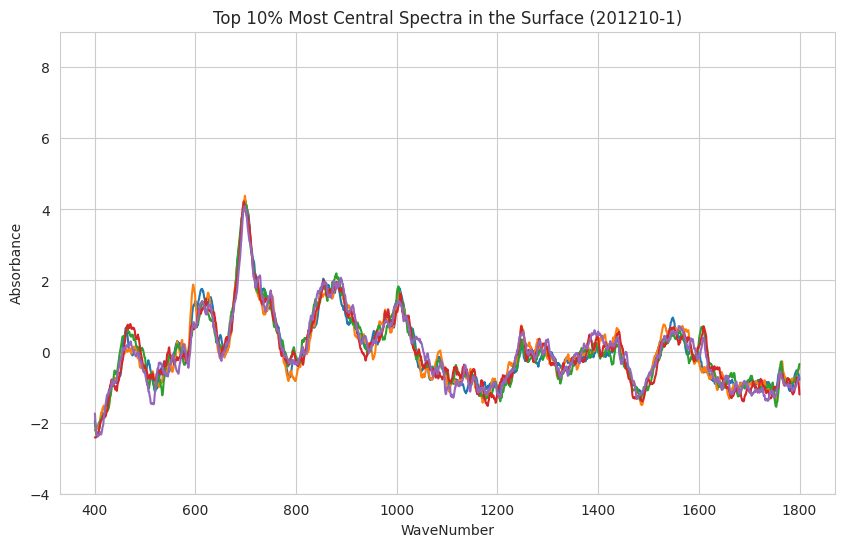

In [107]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the line plot
sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

# Display the plot
plt.title('Top 10% Most Central Spectra in the Surface (201210-1)')
plt.ylim(-4, 9)
plt.show()

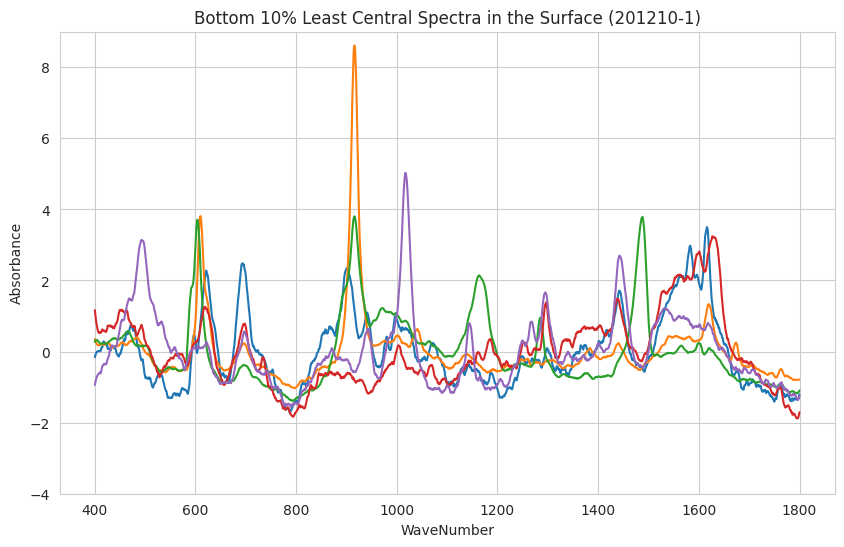

In [108]:
# Set the size of the plot
plt.figure(figsize=(10, 6))


sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

# Display the plot
plt.title('Bottom 10% Least Central Spectra in the Surface (201210-1)')
plt.ylim(-4, 9)
plt.show()

In [103]:
filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
evaluate_extra_trees(filtered_representative_wavelength_df)

KeyboardInterrupt: 

In [ ]:
# percentage = []
# acurate = []

# for num in np.arange(0.7, 0.86, 0.02):
#     median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(num))
#     filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
#     filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
#     accuracy = compare_extra_trees(filtered_representative_wavelength_df)
#     percentage.append(num)
#     acurate.append(accuracy)

# test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

In [ ]:
#sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')

## PageRank Cutofff

In [ ]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,0.016456,0.882796,40.0,10.0
1,201210-1-00,294,400.91116,201210-1,Normal,0.015131,0.882796,40.0,10.0
2,201210-1-00,295,401.59454,201210-1,Normal,0.014097,0.882796,40.0,10.0
3,201210-1-00,296,402.27789,201210-1,Normal,0.013326,0.882796,40.0,10.0
4,201210-1-00,297,402.96127,201210-1,Normal,0.012792,0.882796,40.0,10.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-0.004636,0.988513,33.0,18.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-0.004774,0.988513,33.0,18.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-0.005045,0.988513,33.0,18.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-0.005464,0.988513,33.0,18.0


In [ ]:
PageRank_filter = df[df['PageRank'] > 0.]
opp_PageRank_filter = df[df['PageRank'] <= 0.91]

In [ ]:
fil_sample = PageRank_filter[PageRank_filter['SurID'] == '201210-1']
opp_sample = opp_PageRank_filter[opp_PageRank_filter['SurID'] == '201210-1']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

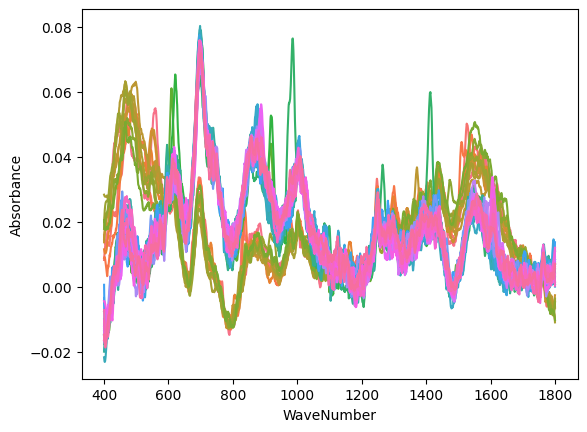

In [ ]:
sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

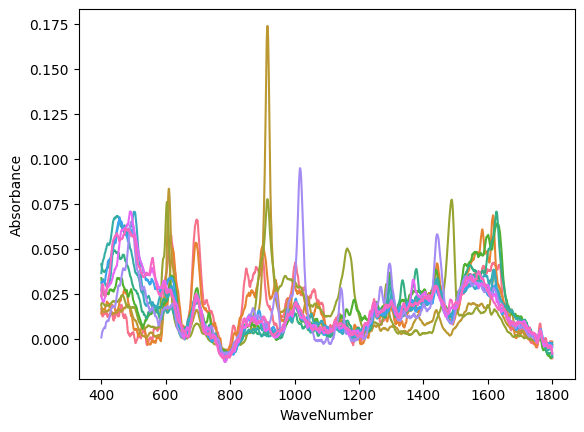

In [ ]:
sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

In [ ]:
PageRank_filter.shape

(4796709, 9)

In [ ]:
percentage = []
acurate = []

for num in np.arange(0.8, 1, 0.01):
    PageRank_filter = df[df['PageRank'] > num]
    filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
    accuracy = compare_extra_trees(filtered_representative_wavelength_df)
    percentage.append(num)
    acurate.append(accuracy)

test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/s

In [ ]:
test_results

,Percentage Cutoff,Accuracy
0,0.80,0.572052
1,0.81,0.586943
2,0.82,0.574530
3,0.83,0.585991
4,0.84,0.605551
5,0.85,0.606241
6,0.86,0.598105
7,0.87,0.608408
8,0.88,0.640618
9,0.89,0.605470


<Axes: xlabel='Percentage Cutoff', ylabel='Accuracy'>

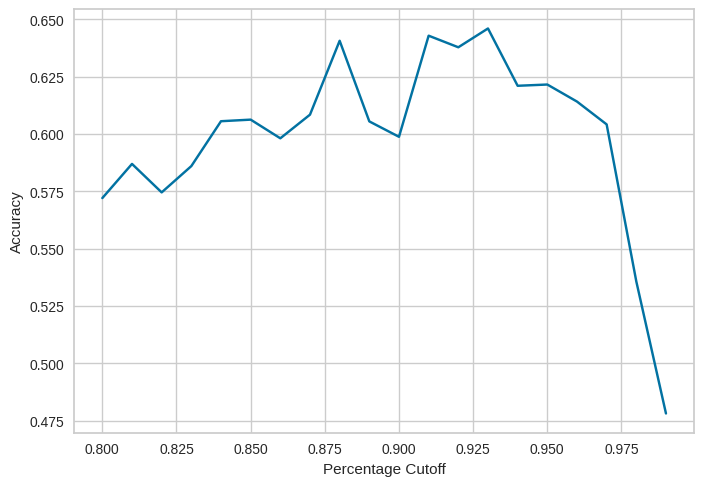

In [ ]:
sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')

In [ ]:
PageRank_filter.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    691
Hypoglycemia     828
Normal           822
Name: SpecID, dtype: int64

In [ ]:
filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
evaluate_extra_trees(filtered_representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6530 +/- 0.1451
ExtraTreesClassifier Cross-Validation Precision: 0.5903 +/- 0.1489
ExtraTreesClassifier Cross-Validation Recall: 0.6007 +/- 0.1622
ExtraTreesClassifier Cross-Validation F1-Score: 0.5740 +/- 0.1546


In [ ]:
from pycaret.classification import *

In [ ]:
caret = setup(data=filtered_representative_wavelength_df, target='Status', session_id=1234, fold_strategy='', fold_groups='SurID')

ValueError: Invalid value for the fold_strategy parameter. Choose from: kfold, stratifiedkfold, groupkfold, timeseries.

In [ ]:
auto_model = compare_models(exclude=['lightgbm', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6586,0.0000,0.6586,0.7439,0.6766,0.4564,0.4786,0.9110
rf,Random Forest Classifier,0.6358,0.0000,0.6358,0.7195,0.6520,0.4297,0.4532,1.5230
knn,K Neighbors Classifier,0.5865,0.0000,0.5865,0.6586,0.6016,0.3446,0.3610,0.7440
lr,Logistic Regression,0.5349,0.0000,0.5349,0.6331,0.5573,0.2739,0.2939,5.6290
svm,SVM - Linear Kernel,0.4435,0.0000,0.4435,0.5929,0.4313,0.1781,0.2101,0.8880
nb,Naive Bayes,0.4065,0.0000,0.4065,0.5349,0.3210,0.0636,0.1111,0.7290
ridge,Ridge Classifier,0.3915,0.0000,0.3915,0.5010,0.4180,0.0771,0.0826,0.8370
dt,Decision Tree Classifier,0.3388,0.0000,0.3388,0.1469,0.2019,0.0000,0.0000,0.8750
ada,Ada Boost Classifier,0.3388,0.0000,0.3388,0.1469,0.2019,0.0000,0.0000,5.2090
qda,Quadratic Discriminant Analysis,0.3330,0.0000,0.3330,0.3266,0.3077,-0.0141,-0.0210,1.0530


In [ ]:
tuned_auto_model = tune_model(auto_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6000,0.0000,0.6000,0.6785,0.5886,0.4120,0.4375
1,0.5241,0.0000,0.5241,0.5425,0.5124,0.2513,0.2644
2,0.9034,0.0000,0.9034,0.9712,0.9345,0.8163,0.8248
3,0.6966,0.0000,0.6966,0.7531,0.6886,0.5139,0.5377
4,0.5655,0.0000,0.5655,0.6559,0.5586,0.3779,0.4234
5,0.7908,0.0000,0.7908,0.7913,0.7907,0.6307,0.6311
6,0.5517,0.0000,0.5517,0.5598,0.5358,0.3386,0.3506
7,0.6316,0.0000,0.6316,0.8016,0.7065,0.3640,0.3911
8,0.4863,0.0000,0.4863,0.6768,0.5658,0.1950,0.2174


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score

In [ ]:
filtered_representative_wavelength_df = filtered_representative_wavelength_df.reset_index()

In [ ]:
filtered_representative_wavelength_df

,SpecID,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
0,201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
1,201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
2,201210-1-07,39.462860,42.711925,45.566652,48.047821,50.176210,51.972598,53.457765,54.652490,55.577550,...,-2.064596,-1.131661,-0.068325,1.129734,2.466836,3.947304,5.575458,7.355619,201210-1,Normal
3,201210-1-09,33.555879,32.770986,32.224594,31.908447,31.814287,31.933857,32.258899,32.781157,33.492374,...,4.141024,3.922734,3.609542,3.193530,2.666778,2.021368,1.249381,0.342898,201210-1,Normal
4,201210-1-10,7.119245,5.805041,4.760513,3.977969,3.449720,3.168075,3.125344,3.313838,3.725866,...,-1.559086,-1.356515,-1.106885,-0.809138,-0.462212,-0.065047,0.383419,0.884246,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,210526-3-45,11.003178,12.008451,12.879986,13.624553,14.248922,14.759862,15.164145,15.468539,15.679816,...,6.671003,7.197072,7.711103,8.211164,8.695324,9.161650,9.608210,10.033072,210526-3,Hyperglycemia
2090,210526-3-46,14.239653,13.596345,12.981340,12.396227,11.842591,11.322020,10.836101,10.386421,9.974566,...,2.124074,2.718437,3.405898,4.190762,5.077335,6.069920,7.172824,8.390352,210526-3,Hyperglycemia
2091,210526-3-47,17.165901,17.349777,17.457499,17.494696,17.466999,17.380039,17.239446,17.050852,16.819887,...,6.895403,7.740965,8.633346,9.572405,10.558000,11.589990,12.668233,13.792588,210526-3,Hyperglycemia
2092,210526-3-48,15.865434,14.551958,13.412815,12.441007,11.629535,10.971400,10.459605,10.087150,9.847038,...,8.137265,9.444800,10.919724,12.570428,14.405304,16.432743,18.661137,21.098876,210526-3,Hyperglycemia


In [ ]:
def leave_one_out_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['SpecID', 'Status', 'SurID'], axis=1)
    y = df['Status']

    logo = LeaveOneGroupOut()

    # Creating the Extra Trees classifier
    model = ExtraTreesClassifier(random_state=1234)
    
    # This will store the accuracy for each group
    group_accuracies = {}

    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train.values.ravel())
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions)
        
        # Assuming groups is a pandas Series or similar, you can get the unique group for this split
        # This assumes each test set in leave-one-group-out has exactly one unique group
        test_group = groups.iloc[test_idx].unique()
        assert len(test_group) == 1, "Each test set should correspond to exactly one group."
        test_group_name = test_group[0]  # The unique group name/identifier for this split
        
        group_accuracies[test_group_name] = score

    return group_accuracies

In [ ]:
leave_one_out_scores = leave_one_out_extra_trees(filtered_representative_wavelength_df)

In [ ]:
for i, r in filtered_representative_wavelength_df.iterrows():
    if r['SurID'] in bad_surfaces:
        filtered_representative_wavelength_df.drop(index=i, inplace=True)

In [ ]:
filtered_representative_wavelength_df

,SpecID,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
0,201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
1,201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
2,201210-1-07,39.462860,42.711925,45.566652,48.047821,50.176210,51.972598,53.457765,54.652490,55.577550,...,-2.064596,-1.131661,-0.068325,1.129734,2.466836,3.947304,5.575458,7.355619,201210-1,Normal
3,201210-1-09,33.555879,32.770986,32.224594,31.908447,31.814287,31.933857,32.258899,32.781157,33.492374,...,4.141024,3.922734,3.609542,3.193530,2.666778,2.021368,1.249381,0.342898,201210-1,Normal
4,201210-1-10,7.119245,5.805041,4.760513,3.977969,3.449720,3.168075,3.125344,3.313838,3.725866,...,-1.559086,-1.356515,-1.106885,-0.809138,-0.462212,-0.065047,0.383419,0.884246,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,210526-3-45,11.003178,12.008451,12.879986,13.624553,14.248922,14.759862,15.164145,15.468539,15.679816,...,6.671003,7.197072,7.711103,8.211164,8.695324,9.161650,9.608210,10.033072,210526-3,Hyperglycemia
2090,210526-3-46,14.239653,13.596345,12.981340,12.396227,11.842591,11.322020,10.836101,10.386421,9.974566,...,2.124074,2.718437,3.405898,4.190762,5.077335,6.069920,7.172824,8.390352,210526-3,Hyperglycemia
2091,210526-3-47,17.165901,17.349777,17.457499,17.494696,17.466999,17.380039,17.239446,17.050852,16.819887,...,6.895403,7.740965,8.633346,9.572405,10.558000,11.589990,12.668233,13.792588,210526-3,Hyperglycemia
2092,210526-3-48,15.865434,14.551958,13.412815,12.441007,11.629535,10.971400,10.459605,10.087150,9.847038,...,8.137265,9.444800,10.919724,12.570428,14.405304,16.432743,18.661137,21.098876,210526-3,Hyperglycemia


In [ ]:
evaluate_extra_trees(filtered_representative_wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.7284 +/- 0.0850
ExtraTreesClassifier Cross-Validation Precision: 0.6960 +/- 0.1276
ExtraTreesClassifier Cross-Validation Recall: 0.6929 +/- 0.1405
ExtraTreesClassifier Cross-Validation F1-Score: 0.6606 +/- 0.1327


In [ ]:
leave_df = pd.DataFrame(columns=['SurID', 'Accuracy'])

In [ ]:
leave_df['SurID'] = leave_one_out_scores.keys()
leave_df['Accuracy'] = leave_one_out_scores.values()

In [ ]:
status_leave_df = status_df.groupby(['SurID', 'Status']).first().reset_index()

In [ ]:
leave_df = pd.merge(leave_df, status_leave_df, how='inner', on='SurID')

In [ ]:
leave_df.head(20)

,SurID,Accuracy,Status
0,201210-1,0.761905,Normal
1,201210-2,0.000000,Normal
2,210114-1,0.930233,Normal
3,210114-2,0.857143,Normal
4,210120-1,0.444444,Hyperglycemia
5,210120-2,0.380952,Hyperglycemia
6,210121-1,0.571429,Hyperglycemia
7,210121-2,0.600000,Hyperglycemia
8,210211-1,1.000000,Hyperglycemia
9,210211-2,0.350000,Hyperglycemia


In [ ]:
Average_acc = leave_df.groupby('Status')['Accuracy'].mean().reset_index()

In [ ]:
Average_acc

,Status,Accuracy
0,Hyperglycemia,0.636291
1,Hypoglycemia,0.587700
2,Normal,0.678607


In [ ]:
just_zero = leave_df[leave_df['Accuracy'] < 0.33]

In [ ]:
just_zero

,SurID,Accuracy,Status
1,201210-2,0.000000,Normal
12,210218-1,0.250000,Hyperglycemia
18,210304-1,0.000000,Hypoglycemia
19,210304-2,0.000000,Hypoglycemia
20,210310-1,0.000000,Normal
27,210318-2,0.187500,Hypoglycemia
34,210407-1,0.074074,Hypoglycemia
35,210407-2,0.111111,Normal
49,210504-2,0.057143,Hypoglycemia
59,210524-1,0.000000,Hypoglycemia


In [ ]:
bad_surfaces = just_zero['SurID'].tolist()

In [ ]:
sample = df[df['Accuracy'] == '']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

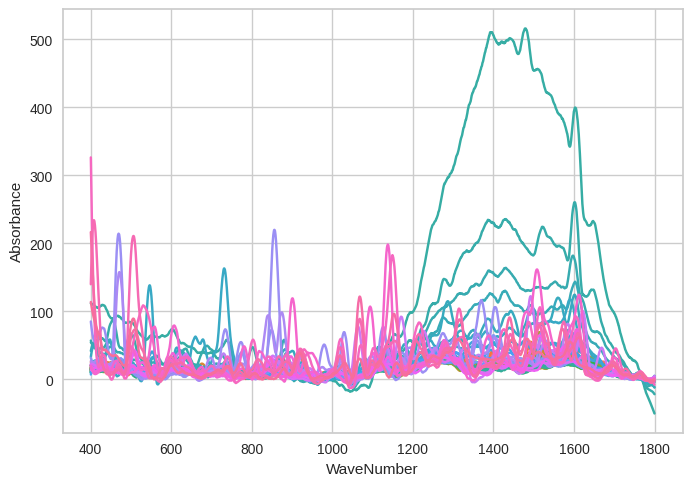

In [ ]:
sns.lineplot(data=sample, x='WaveNumber', y='Absorbance', hue='SpecID', legend=False)

In [ ]:
sample2 = df[df['SurID'] == '210211-1']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

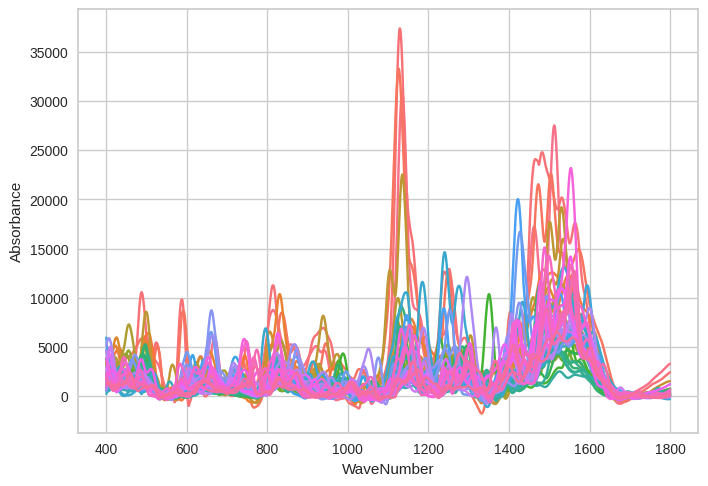

In [ ]:
sns.lineplot(data=sample2, x='WaveNumber', y='Absorbance', hue='SpecID', legend=False)

In [ ]:
filtered_representative_wavelength_df.shape

(2094, 2051)

In [ ]:
# percentage = []
# acurate = []

# for num in np.arange(0.8, 0.86, 0.005):
#     PageRank_filter = df[df['PageRank'] > num]
#     filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
#     accuracy = compare_extra_trees(filtered_representative_wavelength_df)
#     percentage.append(num)
#     acurate.append(accuracy)

# test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

In [ ]:
test_results

NameError: name 'test_results' is not defined

<Axes: xlabel='Percentage Cutoff', ylabel='Accuracy'>

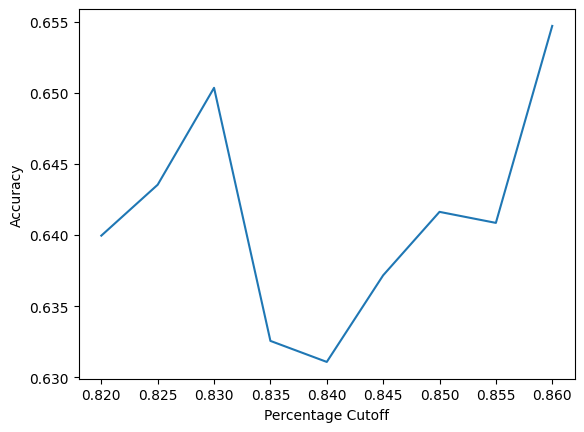

In [ ]:
sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')